<a href="https://colab.research.google.com/github/Cyazar/fastai/blob/main/notebooks/inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

This notebook shows how to run inference with the [MAXIM family of models](https://github.com/google-research/maxim) from [TensorFlow Hub](https://tfhub.dev/sayakpaul/collections/maxim/1). MAXIM family of models share the same backbone for performing: denoising, dehazing, deblurring, deraining, and enhancement. You can know more about the public MAXIM models from [here](https://github.com/google-research/maxim#results-and-pre-trained-models).

## Select a checkpoint

In [1]:
task = "Retouching"  # @param ["Denoising", "Dehazing_Indoor", "Dehazing_Outdoor", "Deblurring", "Deraining", "Enhancement", "Retouching"]

model_handle_map = {
    "Denoising": [
        "https://tfhub.dev/sayakpaul/maxim_s-3_denoising_sidd/1",
        "https://github.com/google-research/maxim/raw/main/maxim/images/Denoising/input/0003_30.png",
    ],
    "Dehazing_Indoor": [
        "https://tfhub.dev/sayakpaul/maxim_s-2_dehazing_sots-indoor/1",
        "https://github.com/google-research/maxim/raw/main/maxim/images/Dehazing/input/0003_0.8_0.2.png",
    ],
    "Dehazing_Outdoor": [
        "https://tfhub.dev/sayakpaul/maxim_s-2_dehazing_sots-outdoor/1",
        "https://github.com/google-research/maxim/raw/main/maxim/images/Dehazing/input/1444_10.png",
    ],
    "Deblurring": [
        "https://tfhub.dev/sayakpaul/maxim_s-3_deblurring_gopro/1",
        "https://github.com/google-research/maxim/raw/main/maxim/images/Deblurring/input/1fromGOPR0950.png",
    ],
    "Deraining": [
        "https://tfhub.dev/sayakpaul/maxim_s-2_deraining_raindrop/1",
        "https://github.com/google-research/maxim/raw/main/maxim/images/Deraining/input/15.png",
    ],
    "Enhancement": [
        "https://tfhub.dev/sayakpaul/maxim_s-2_enhancement_lol/1",
        "https://github.com/google-research/maxim/raw/main/maxim/images/Enhancement/input/a4541-DSC_0040-2.png",
    ],
    "Retouching": [
        "https://tfhub.dev/sayakpaul/maxim_s-2_enhancement_fivek/1",
        "https://github.com/google-research/maxim/raw/main/maxim/images/Enhancement/input/a4541-DSC_0040-2.png",
    ],
}

model_handle = model_handle_map[task]
ckpt = model_handle[0]
print(f"TF-Hub handle: {ckpt}.")

TF-Hub handle: https://tfhub.dev/sayakpaul/maxim_s-2_enhancement_fivek/1.


For deblurring, there are other checkpoints too:

* https://tfhub.dev/sayakpaul/maxim_s-3_deblurring_realblur_r/1
* https://tfhub.dev/sayakpaul/maxim_s-3_deblurring_realblur_j/1
* https://tfhub.dev/sayakpaul/maxim_s-3_deblurring_reds/1

## Imports

In [4]:
import tensorflow as tf
import tensorflow_hub as hub

import matplotlib.pyplot as plt

from PIL import Image
import numpy as np

## Fetch the input image based on the task

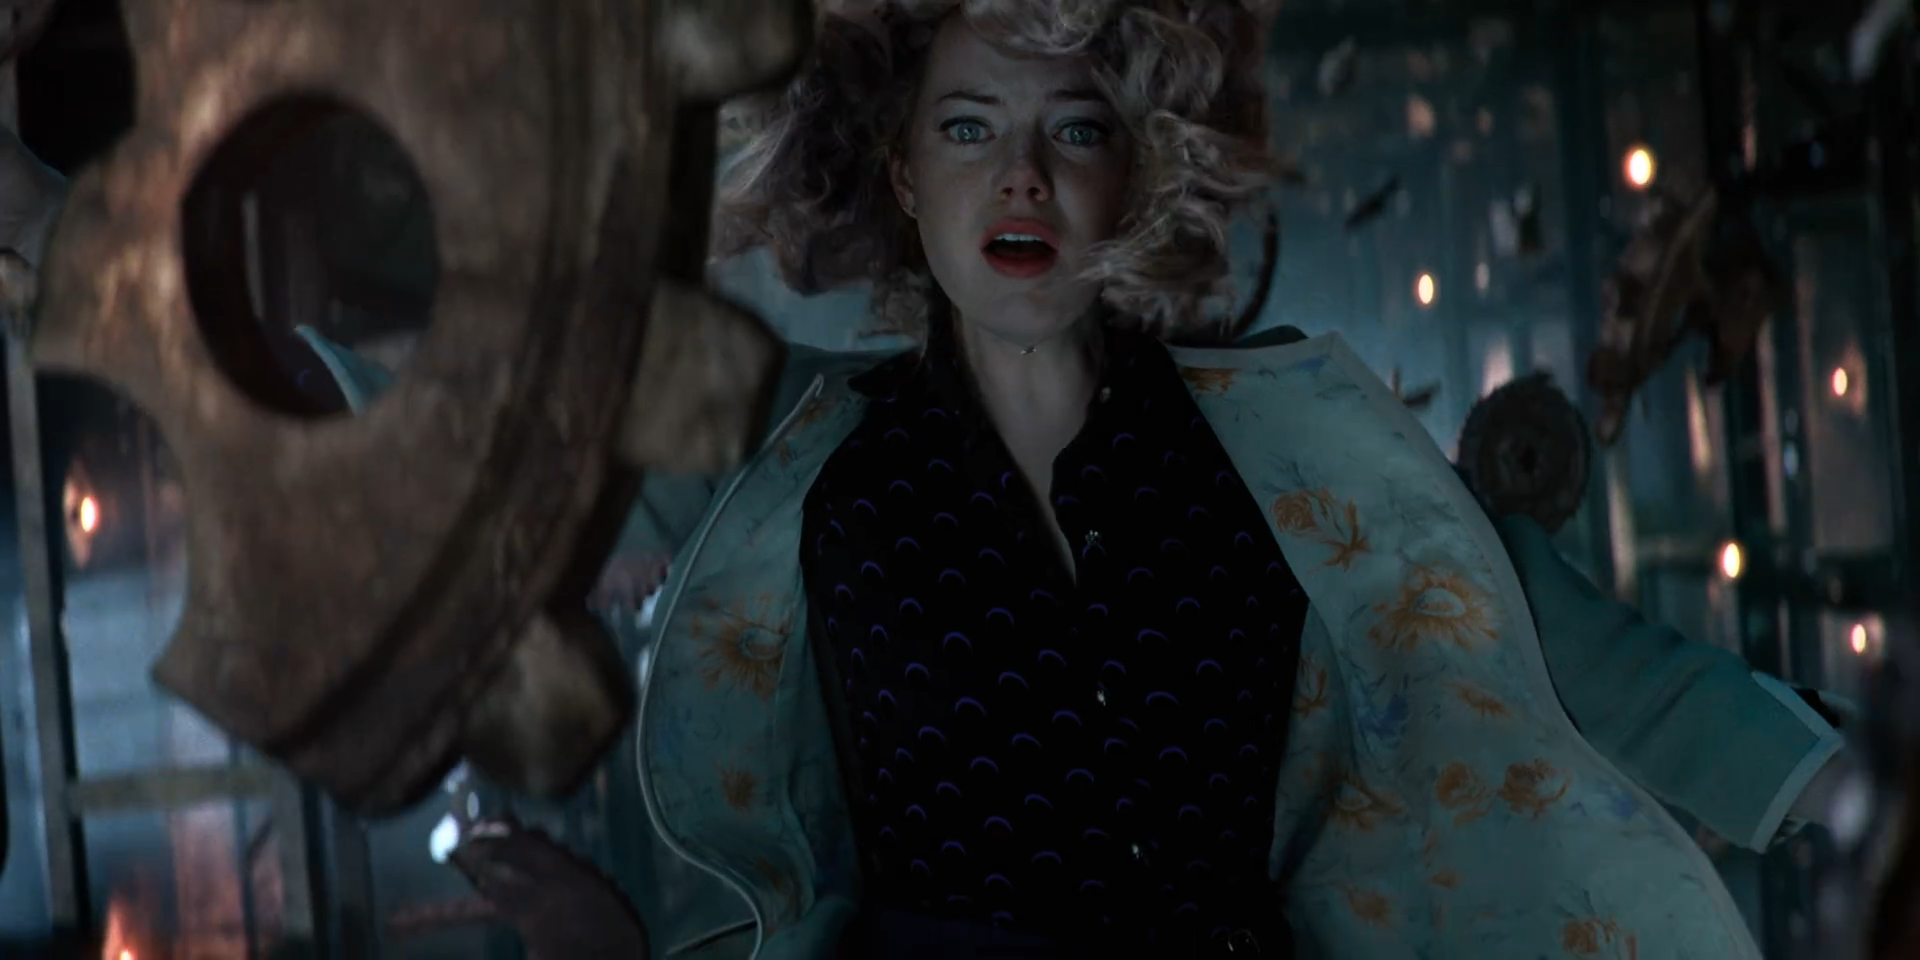

In [5]:
image_url = model_handle[1]
image_path = '/content/emmahdr.png'#tf.keras.utils.get_file(origin=image_url)
Image.open(image_path)

## Preprocessing utilities

Based on [this official script](https://github.com/google-research/maxim/blob/main/maxim/run_eval.py).

In [6]:
# Since the model was not initialized to take variable-length sizes (None, None, 3),
# we need to be careful about how we are resizing the images.
# From https://www.tensorflow.org/lite/examples/style_transfer/overview#pre-process_the_inputs
def resize_image(image, target_dim):
    # Resize the image so that the shorter dimension becomes `target_dim`.
    shape = tf.cast(tf.shape(image)[1:-1], tf.float32)
    short_dim = min(shape)
    scale = target_dim / short_dim
    new_shape = tf.cast(shape * scale, tf.int32)
    image = tf.image.resize(image, new_shape)

    # Central crop the image.
    image = tf.image.resize_with_crop_or_pad(image, target_dim, target_dim)

    return image


def process_image(image_path, target_dim=256):
    input_img = np.asarray(Image.open(image_path).convert("RGB"), np.float32) / 255.0
    input_img = tf.expand_dims(input_img, axis=0)
    input_img = resize_image(input_img, target_dim)
    return input_img

This notebook infers on fixed-shape images. However, MAXIM can handle images of any resolution. The current implementation in TensorFlow can achieve this with a bit of hacking. Please refer to [this notebook](https://github.com/sayakpaul/maxim-tf/blob/main/notebooks/inference-dynamic-resize.ipynb) if you want the model to infer on dynamic shapes. 

## Run predictions

In [7]:
def get_model(model_url: str, input_resolution: tuple) -> tf.keras.Model:
    inputs = tf.keras.Input((*input_resolution, 3))
    hub_module = hub.KerasLayer(model_url)

    outputs = hub_module(inputs)

    return tf.keras.Model(inputs, outputs)


# Based on https://github.com/google-research/maxim/blob/main/maxim/run_eval.py
def infer(image_path: str, model: tf.keras.Model, input_resolution=(256, 256)):
    preprocessed_image = process_image(image_path, input_resolution[0])

    preds = model.predict(preprocessed_image)
    if isinstance(preds, list):
        preds = preds[-1]
        if isinstance(preds, list):
            preds = preds[-1]

    preds = np.array(preds[0], np.float32)
    final_pred_image = np.array((np.clip(preds, 0.0, 1.0)).astype(np.float32))
    return final_pred_image

In [8]:
input_resolution = (256, 256)

model = get_model(ckpt, input_resolution)

final_pred_image = infer(image_path, model, input_resolution)

1/1 [==============================] - 28s 28s/step


## Visualize results

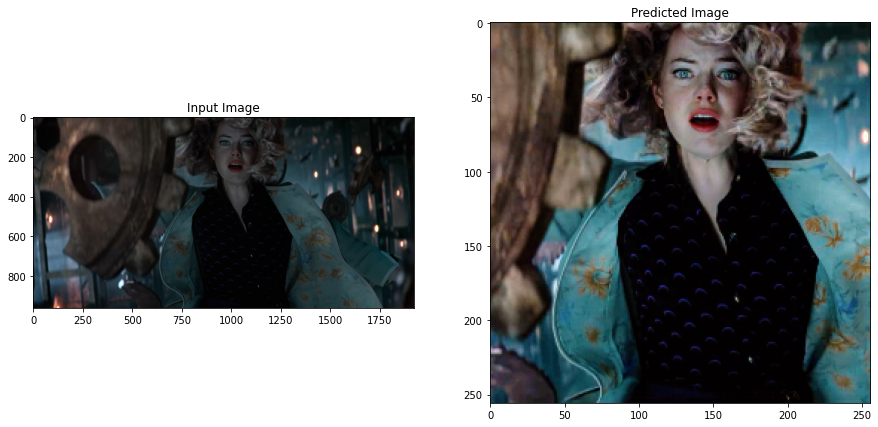

In [9]:
# Based on https://www.tensorflow.org/lite/examples/style_transfer/overview#visualize_the_inputs
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title:
        plt.title(title)


plt.figure(figsize=(15, 15))

plt.subplot(1, 2, 1)
input_image = np.asarray(Image.open(image_path).convert("RGB"), np.float32) / 255.0
imshow(input_image, "Input Image")

plt.subplot(1, 2, 2)
imshow(final_pred_image, "Predicted Image")

In [10]:
import matplotlib.image

matplotlib.image.imsave('/content/your_file.png', final_pred_image)
#process_image ('/content/emmahdr_.png', (480, 240)))

In [11]:
type(final_pred_image)

numpy.ndarray